In [1]:
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import matplotlib.cm as mpl_cm
import seaborn as sns
import pathlib
from astropy.io import fits
pd.options.display.max_rows = None
%matplotlib inline
sns.set(context='notebook',style='ticks',font_scale=1.5,palette='bright')

#Constants for data reduction
sol = 299792458 #m/s
planck_joule = 6.6267015e-34 #Joule s
elemcharge =  1.602176634e-19 #coulombs
planck = planck_joule / elemcharge #eV s
metertoang = 10**(10)

In [2]:
### enter the path to the folder that contains the scan images

path_s = pathlib.Path('C:/Users/tjf2/Documents/SynchrotronData/ALS/2020 Dec/Data_12122020/Plate1_Data/MF114C/ppol/250eV')     
path_s = pathlib.Path('C:/Users/tjf2/Documents/SynchrotronData/ALS/2020 Nov/LateNov_Data/Late_Nov_Summary/MF114Old/spol/250eV')     


files = list(path_s.glob('*fits'))
files_df = pd.DataFrame(files)
display(files_df.head())
display(files_df.tail())

,0
0,C:\Users\tjf2\Documents\SynchrotronData\ALS\20...
1,C:\Users\tjf2\Documents\SynchrotronData\ALS\20...
2,C:\Users\tjf2\Documents\SynchrotronData\ALS\20...
3,C:\Users\tjf2\Documents\SynchrotronData\ALS\20...
4,C:\Users\tjf2\Documents\SynchrotronData\ALS\20...


,0
397,C:\Users\tjf2\Documents\SynchrotronData\ALS\20...
398,C:\Users\tjf2\Documents\SynchrotronData\ALS\20...
399,C:\Users\tjf2\Documents\SynchrotronData\ALS\20...
400,C:\Users\tjf2\Documents\SynchrotronData\ALS\20...
401,C:\Users\tjf2\Documents\SynchrotronData\ALS\20...


In [3]:
from ALS11012_prsoxr_loader import *

In [4]:
mask = np.full((200,200), True)
#mask[150:,:] = False
mask[120:,:] = False
test = ALS_PRSoXR_Loader(files, name='Test',mask=mask)

In [5]:
#ax = test.normalized_data.plot(x='Q', y='R')
#refl.plot(x='Q', y='R', ax=ax)
#plt.yscale('log')


In [6]:
test.calc_reflectivity()
test.calc_I0()

In [7]:
test.find_stitch_points()
test.calc_scale_factors()

11.0
10.0
7.5
500.0
1000.0


In [11]:
refl = test.stitch_refl()

In [12]:
#test.data

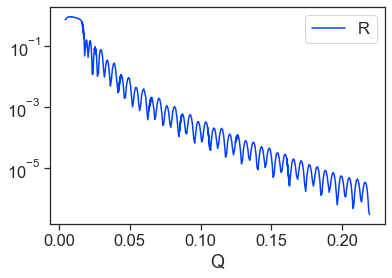

In [13]:
refl.plot(x='Q', y='R')
plt.yscale('log')

In [ ]:
#test.raw_images

In [ ]:
test.meta['EXPOSURE'].iloc[10]

In [ ]:
mask = np.full((200,200), True)
#mask[150:,:] = False
mask[120:,:] = False
image, _, _, _ = check_spot(file=files[10], mask=mask, h=15,w=40, diz_threshold=10, diz_size=3)

In [ ]:
### uncomment and run commands below to view file info and header contents of the first image

#hdul = fits.open(files[10])
#hdul[0].header

In [165]:
### this function finds the brightest pixel on the image and draws a box of dimensions h and w around it (it ignores the out edge)
"""
Inputs
    IMAGE_orig - Image to process
    h / w - (int) height and width of the box to calculate the reflectivity
    edge - (tuple) Amount ot remove from the edge of the image before processing
    guess_loc (tuple) Guess for where the center of the beam should be located - used to prevent too much beam drift
    dispTolerance (int) How far you allow the beam to drift within 2 images before it errors (Set to 100 to ignore)
    MASK_orig (Boolean Array) - Array of values to select which points to include 'FALSE' values are not included in beam hunt
    rect (Boolean) If you want to export the location of the averaged rectangle for visualization
    diz Threshold/Size - Dizinger information, NOT USED RIGHT NOW
"""
def slice_spot(IMAGE_orig, h, w, edge=(5,5), guess_loc=None, dispTolerance=100, MASK_orig=None, rect=False, dizThreshold=1.5, dizSize=3): 
    dx=edge[0]
    dy=edge[1]
    
    #Check if mask is an array, if not, generate a dummy mask to prevent errors
    if MASK_orig is None:
        MASK_orig = np.full(IMAGE_orig.shape, True) #No Mask
    elif MASK_orig.shape != IMAGE_orig.shape:
        print('ERROR: Mask shape mismatch')
        print('Continuing w/o mask')
        MASK_orig = np.full(IMAGE_orig.shape, True)
    
    #IMAGE_MASKED = np.copy(IMAGE_orig[dx:-dx,dy:-dy])
    IMAGE_MASKED, IMAGE_LOCBEAM = DezingerImage(IMAGE_orig[dx:-dx,dy:-dy], THRESHOLD=dizThreshold, SIZE=dizSize)
    #IMAGE_LOCBEAM = IMAGE_MASKED
    MASK = MASK_orig[dx:-dx,dy:-dy]# Cut the edge off the mask as well
    IMAGE_MASKED[~MASK]=0 #Use Boolean Indexing to set all 'False' pixel to 0 for the sake of finding the image maximum
    IMAGE_LOCBEAM[~MASK]=0
    
    #y_spot_test,x_spot_test=np.unravel_index(np.argmax(IMAGE_MASKED),IMAGE_MASKED.shape) #Find the highest pixel
    y_spot_test,x_spot_test=np.unravel_index(np.argmax(IMAGE_LOCBEAM),IMAGE_LOCBEAM.shape) #Find the highest pixel

    #Check the location of the newest spot and compare to the 'guess' (informed by previous images)
    """
    if type(guess_loc) is tuple:
        displacement = BeamDisplacement(guess_loc, (x_spot_test, y_spot_test))
        #if the new location is beyond some Threshold, use the guess position instead
        #This is to prevent a 'hot pixel' from relocating the beam. 
        #Since image to image should have minimal drift, this should approximate the expected location.
        if displacement > dispTolerance: 
            x_spot_test = guess_loc[0]
            y_spot_test = guess_loc[1]
    """
    y_spot = y_spot_test - (h//2)+dy
    x_spot = x_spot_test - (w//2)+dx
   
    sl1 = slice(y_spot,y_spot+h)
    sl2 = slice(x_spot,x_spot+w)
    sl_spot = (sl1,sl2)
    IMAGE_SPOT = IMAGE_orig[sl_spot]
    
    if rect:
        rect_spot = plt.Rectangle((x_spot, y_spot),w,h,edgecolor='green',facecolor='None')
        return IMAGE_SPOT, (x_spot_test, y_spot_test), rect_spot
    return IMAGE_SPOT, (x_spot_test, y_spot_test), IMAGE_LOCBEAM

### this function draws a  box of equal size that is used to compute background counts

def slice_dark(IMAGE_orig, h, w, edge=(5,5), beam_loc=(75,75), darkside='LHS', rect=False):   
    dx=edge[0]
    dy=edge[1]
    IMAGE=IMAGE_orig[dx:-dx,dy:-dy]
    #y_spot_test,x_spot_test=np.unravel_index(np.argmax(IMAGE),IMAGE.shape)
    #x_dark =  IMAGE_orig.shape[0]-edge-w  ### box on right side of image
    
    #x_spot_test = beam_loc[0]

    y_spot_test = beam_loc[1]
    if darkside == 'LHS':
        x_dark =  edge[0]  ### box on left side of image
    elif darkside == 'RHS':
        x_dark =  IMAGE_orig.shape[0]-edge[0]-w  ### box on right side of image
    else: #Default to RHS
        x_dark =  IMAGE_orig.shape[0]-edge[0]-w  ### box on right side of image
    
    y_dark =  y_spot_test-(h//2)+dy
        
    sl1 = slice(y_dark,y_dark+h)
    sl2 = slice(x_dark,x_dark+w)
    sl_dark = (sl1,sl2)
    IMAGE_DARK = IMAGE_orig[sl_dark]
    
    if rect:
        rect_dark = plt.Rectangle((x_dark,y_dark),w,h,edgecolor='green',facecolor='None')
        return IMAGE_DARK,rect_dark
    return IMAGE_DARK

"""
UTILITY FUNCTIONS FOR THE ABOVE
"""

#Replace pixels above a threshold with the average defined by a box of SIZE x SIZE around the pixel
#Also returns the averaged display (based on size) for use in defining where the beam center is
def DezingerImage(IMAGE, THRESHOLD=1.5, SIZE=3):
    from scipy import ndimage
    MED_RESULT = ndimage.median_filter(IMAGE, size=SIZE) #Apply Median Filter to image
    DIFF_IMAGE = IMAGE / np.abs(MED_RESULT) #Calculate Ratio of each pixel to compared to a threshold
    
    OUTPUT = IMAGE*np.greater(THRESHOLD, DIFF_IMAGE).astype(int) + MED_RESULT*np.greater(DIFF_IMAGE, THRESHOLD) #Repopulate image by removing pixels that exceed the threshold
    return OUTPUT, MED_RESULT #Return dezingered image and averaged image

#Calculate the displacement of the beam between images
def BeamDisplacement(LOC_ORIG, LOC_NEW):
    import numpy as np
    DISPLACEMENT =  np.linalg.norm(np.array(LOC_ORIG) - np.array(LOC_NEW))
    return DISPLACEMENT


In [166]:
### this function allows you to preview all of the images and see where the specular and background boxes are drawn

def check_spot(file_num=0,h=18,w=15,mask=None): 

    #Constants for data reduction
    SOL = 299792458 #m/s
    PLANCK_JOULE = 6.6267015e-34 #Joule s
    ELEMCHARGE =  1.602176634e-19 #coulombs
    PLANCK = PLANCK_JOULE / ELEMCHARGE #eV s
    meterToAng = 10**(10)
    
    file = files[file_num]
    
    with fits.open(file) as hdul:
        EXPOSURE = hdul[0].header['EXPOSURE']
        beam_current = hdul[0].header['HIERARCH Beam Current']
        ANGLE2 = hdul[0].header['Sample Theta']
        ANGLE = hdul[0].header['T-2T']
        CCD_THETA = hdul[0].header['CCD Theta']
        IMAGE = hdul[2].data
        ENERGY = round(hdul[0].header['HIERARCH Beamline Energy'],2) #eV
        POLARIZATION = hdul[0].header['EPU POLARIZATION']
        HOS = round(hdul[0].header['HIERARCH Higher Order Suppressor'],1)
        HES = hdul[0].header['HIERARCH Horizontal Exit Slit Size']

    print('File: {}'.format(file))
    print('beam_current:',beam_current)
    print('Exposure:',EXPOSURE)
    print('ANGLE:',ANGLE)
    print('ANGLE2',ANGLE2)
    print('CCD Theta:', CCD_THETA)
    print('ENERGY:',ENERGY)
    print('POLARIZATION', POLARIZATION)
    print('HOS:', HOS)
    print('HES:', HES)
    print('Image Size', IMAGE.shape)
    
    LAM = meterToAng*PLANCK*SOL/(ENERGY) #calculate wavelength
    Q = 4 * np.pi * np.sin(ANGLE*np.pi/180)/LAM #calculate q-values
      
    IMAGE_SPOT, beamspot, rect_spot = slice_spot(IMAGE, h, w, MASK_orig=mask, rect=True, edge=(5,5))
    IMAGE_DARK, rect_dark = slice_dark(IMAGE, h, w, beam_loc=beamspot, rect=True)
    I_refl = int(IMAGE_SPOT.sum())
    dark = int(IMAGE_DARK.sum())
    SNR = float((I_refl/dark)) ### "signal to noise ratio" 
    print('Specular:',I_refl)
    print('Background:',dark)
    print('Signal:', I_refl - dark)
    print('SNR:', SNR)
    print('Beam center', beamspot)
        
    fig,ax = plt.subplots(1,3,subplot_kw={'xticks':[],'yticks':[]},figsize=(12,12))
    ax[0].imshow(IMAGE,norm=mpl_colors.LogNorm(),cmap='terrain')
    
    if mask is not None:
        MASK_DISPLAY = np.ma.masked_where(mask == True, mask)
        ax[0].imshow(MASK_DISPLAY,cmap='Greys_r')
        
    ax[1].imshow(IMAGE_SPOT,norm=mpl_colors.LogNorm(),cmap='terrain')
    #ax[2].imshow(IMAGE_LOCBEAM, norm=mpl_colors.LogNorm(), cmap='terrain')
    ax[2].imshow(IMAGE_DARK,norm=mpl_colors.LogNorm(),cmap='terrain')
    ax[0].add_patch(rect_spot)
    ax[0].add_patch(rect_dark)
    plt.show()
    
    print(IMAGE_SPOT.shape[0])
    return IMAGE, IMAGE_SPOT, IMAGE_DARK

File: C:\Users\tjf2\Documents\SynchrotronData\ALS\2020 Nov\LateNov_Data\Late_Nov_Summary\MF114Old\spol\250eV\MFSeries_spol_67235-00383.fits
beam_current: 0.0
Exposure: 1.0
ANGLE: 55.308
ANGLE2 55.308
CCD Theta: 110.6165
ENERGY: 250.0
POLARIZATION 100.0
HOS: 7.5
HES: 1000.0
Image Size (200, 200)
Specular: 449160
Background: 343941
Signal: 105219
SNR: 1.3059216551676014
Beam center (143, 57)


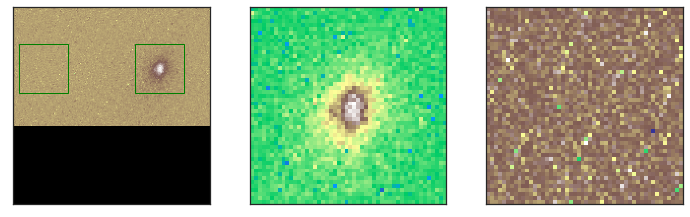

50


In [167]:
mask = np.full((200,200), True)
#mask[150:,:] = False
mask[120:,:] = False
_, Image_spot, Image_dark = check_spot(file_num=-20, mask=mask, h=50,w=50)


In [176]:
### this code processes all of the images using the slider settings defined above.it corrects for background counts, exposure time, and fluctuations in the ring current (which may or may not be correct) 
### make sure the following settings are correct:

#Information for data reduction
shutter_offset =  0.00389278 ### [s] pneumatic shutter = -0.0245; piezo shutter = 0.00474062 ## 0.00389278 (Late November 2020) ## 0.00370251 (April 2021)  ## 0.002008363 (JACOB)
samp_loc = 0  ### sample on bottom of holder = 180, sample on top = 0
angle_offset = 0 #-0.62 ### [deg] Angle offset during sample setup -- reference lab notebook or runfile to get number for scan 
energy_offset = 0 ### [eV] correct for energy offset at the beamline (Should be correct in script generation)
percent_error = 1.5 ### [%] uncerntainty in sum intensity values...used to approximate error ###(NOT USED)
snr_cutoff = 1.01### lower cutoff for SNR: SNR = I_refl/dark ... New beamspot finding algorithm makes it easier to lower. 1.01-1.05 is fine ### (Old: 1.1 appears to be a generally good value for 11.0.1.2)

#Information for Image processing
image_x = 200 #Number of pixels in x dimension #image size, use check_spot() to read if you don't know it
image_y = 200 #Number of pixels in y dimension #See Image_x
box_height = 60 #Height of box to integrate for calculating flux #
box_width = 30 #15 #Width of box to integrate for calculating flux
beamloc = (75, 75) #Guess as to where the beam starts *** Use check_spot() to locate initial position (Not in use right now)
edgetrim = (5,5) #Pixels around the edge to trim
#Dark substraction is accomplished from the same image. Box is drawn at edge of detector at same y-position.
#Images can have an intensity gradient in the vertical image axis so be careful if manually moving dark.
#Decide on the left (LHS) or right (RHS) edge of the detector to take subtraction.
darkside = 'LHS' #Which side of the image do you want to use for a dark: 'LHS' or 'RHS' (Defaults to RHS)

#Dezinger image variables (If gamma rays become a problem)
dizthreshold = 5
dizsize = 3

#Tolerance on beam drift per image
disptolerance = 100 #tolerance of how far the beam center can move each image #Does not do anything

##Generate a mask if necessary.
##Use this to remove slit reflections that interfere with locating the beam
##Pixels with 'False' will not be considered for finding beam location.
mask = np.full((image_x,image_y), True)
mask[120:,:] = False

#mask[150:170,70:130] = False
#mask[150:,:] = False
#mask[:75, :] = False
#mask[95:100,:] = False
#mask=None
################################################
#***********No further user input**************#
################################################
#*************Importing data*******************#
################################################
data = [] #creates data series for processing within this notebook
meta_data = [] #Store data AND meta-data for each image for reference

slice_h = box_height
slice_w = box_width

process_dict = {'shutter_offset' : shutter_offset, 'sample_location' : samp_loc, 'energy_offset' : energy_offset, 'SNR_cutoff' : snr_cutoff,
                'imageX' : image_x, 'ImageY': image_y, 'box_height' : box_height, 'box_width' : box_width, 'edgetrim' : edgetrim,
                'darkside': darkside, 'mask':mask
               }
#process_dict.update({'ImageY': Image_y, 'box_height' : box_height, 'box_width' : box_width, 'edgetrim' : edgetrim, 'darkside': darkside, 'mask':mask})

current_beamloc = beamloc #Generate the iterative variable that will change per each file

#Build and open hdf5 file
for i,file in enumerate(files):
    with fits.open(file) as hdul:
        #Parameters for data reduction
        beam_current = hdul[0].header['HIERARCH Beam Current']
        exposure = hdul[0].header['EXPOSURE']+shutter_offset 
        angle = ((hdul[0].header['T-2T']+samp_loc))*np.pi/180
        ccd_theta = ((hdul[0].header['CCD Theta'])) * np.pi/180
        #ANGLE_deg = hdul[0].header['T-2T']
        energy = round(hdul[0].header['HIERARCH Beamline Energy'],1)+energy_offset #eV
        polarization = hdul[0].header['EPU POLARIZATION']
        hos = round(hdul[0].header['HIERARCH Higher Order Suppressor'],1)
        hes = hdul[0].header['HIERARCH Horizontal Exit Slit Size']
        ai3 = hdul[0].header['HIERARCH AI 3 Izero']
        image = hdul[2].data
        #Grab header for meta-data 
        header = hdul[0].header
    #Angle_Offset = (CCD_THETA)/2*np.pi/180 - ANGLE

    lam = metertoang*planck*sol/(energy) #calculate wavelength
    if ccd_theta == 0: #Locate the direct beam images
        q= 0
    else:
        q = 4 * np.pi * np.sin(angle - np.radians(angle_offset))/lam #calculate q-value and correcty for theta offset

    image_spot, current_beamloc, image_locbeam = slice_spot(image, h=slice_h, w=slice_w, edge=edgetrim, guess_loc=current_beamloc,
                                                            dispTolerance=disptolerance, MASK_orig=mask, dizThreshold=dizthreshold, dizSize=dizsize)
    image_dark = slice_dark(image, h=slice_h, w=slice_w, edge=edgetrim, beam_loc=current_beamloc, darkside=darkside)

    i_tot = int(image_spot.sum())
    dark = int(image_dark.sum())

    skip=False
    if i_tot <= 0:
        skip = True
    elif dark <= 0:
        skip = True
    else:
        snr = i_tot/dark ### "signal to noise ratio"

    if snr < snr_cutoff:
        skip = True
    else:
        i_refl = (i_tot - dark)
        r = ((i_tot - dark))/(exposure)#*beam_current)# calculate reflectivity
        r_err = np.sqrt(i_tot + dark)/(exposure)#*beam_current) ###(I_refl/I_tot)*
        snr = float(r/r_err)
        #R_err = (((I_refl*(percent_error/100))**2+(dark*(percent_error/100))**2)**(0.5))/(EXPOSURE)#*beam_current)
        #data.append([Q,R,R_err,HOS,HES]) #store q, reflectivity, error, and HOS values
        meta_data.append([i, q, r, r_err, i_tot, dark, snr, hos, hes, exposure, energy, polarization, angle, beam_current, ai3,
                          current_beamloc[0], current_beamloc[1]])

##Collate Meta data and un-normalized data into a dataframe
meta_columns = ['SCAN INDEX', 'Q','R', 'R_err', 'I_tot', 'I_dark', 'SNR', 'HOS', 'HES', 'EXPOSURE', 'ENERGY', 'POLARIZATION', 'ANGLE', 'BEAM_CURRENT', 'AI3 CURRENT','BEAM_LOCATION_X', 'BEAM_LOCATION_Y']
meta = pd.DataFrame(meta_data,columns=meta_columns)


In [177]:
### this code puts processed image data into dataframes and corrects the reflectivity for the incident beam
columns = ['Q', 'R', 'R_err', 'HOS', 'HES'] #Make sure motors that are expected to impact intensity are included here
data = meta[['Q', 'R', 'R_err', 'HOS', 'HES']] #Pull important data from the metadata

#Compile data
refl = pd.DataFrame(data, columns=(columns))
### Find the number of datapoints used for the I0 calculaton (# of datapoints at q=0)

I0_cutoff = refl['Q'].where(refl['Q'] == 0).count() ##How many data points in the collection of images are at q=0
if I0_cutoff > 0:
    direct_beam = refl['R'].iloc[:I0_cutoff].mean() ##Average the frames that make up I0
    direct_beam_err = refl['R'].iloc[:I0_cutoff].std()/refl['R'].iloc[:I0_cutoff].mean() #Calculate the StdErr of the I0 for later propagation
else:
    direct_beam = 1
    direct_beam_err = 0
print(I0_cutoff)
    
refl['R_err'] = np.sqrt((refl['R']/direct_beam)**2 * ((refl['R_err']/refl['R'])**2 + direct_beam_err**2))#correct for incident intensity
refl['R']=refl['R']/direct_beam   #correct for incident intensity
#refl['R_err'] = refl['R_err']/direct_beam
#refl = refl.drop(refl.index[:10])  #drop direct beam measurement from p-RSoXR profile

refl = refl.drop(refl.index[:I0_cutoff])  #drop direct beam measurement from p-RSoXR profile


10


(100000000.0, 300000000.0)

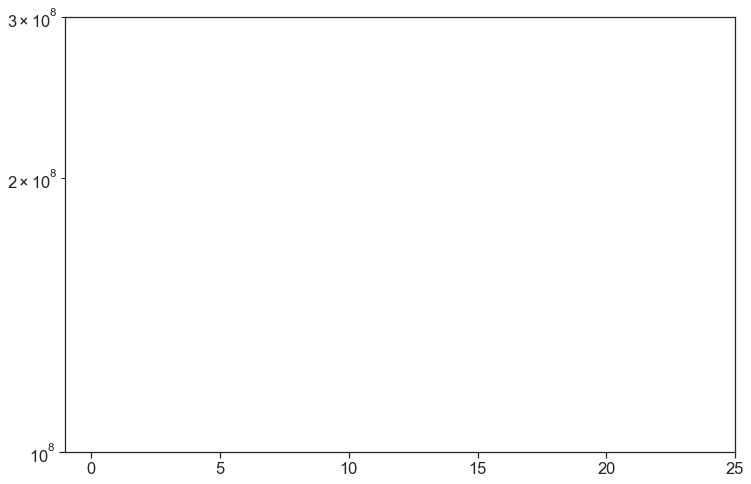

In [170]:
#First location to plot data and check if it looks OK.]

ax = refl['R'].plot(marker='o',ms=3,logy=True,yerr=refl["R_err"],figsize=(12,8))
plt.xlim(-1,25)
plt.ylim(1e8,3e8)
#meta['EXPOSURE'].plot(ax=ax, secondary_y=True)
#plt.xlim(0,70)
#ax = refl["HOS"].plot(secondary_y = True, marker='o',ms=3,logy=False)
#ax = meta['I_tot'].plot(x='Q',marker='o',ms=3, logy=True, figsize=(12,8))
#ax = meta['I_dark'].plot(x='Q',marker='o',ms=3)
#ax = meta["SNR"].plot(secondary_y = True, marker='o',ms=3,logy=False)


#axes = plt.gca()
#ax.set(xlabel='q',ylabel='R')
#ax.legend(loc='lower right',bbox_to_anchor=(1.0,0.5))
#ax.set(xlabel='q',ylabel='motor')
#ax.legend(loc='lower right',bbox_to_anchor=(1.0,0.5))


In [171]:
### this code finds the parts of the scan where the HOS/HES settings are changed

df=refl.drop(['Q','R','R_err'], axis=1) #Drop everything except the motors that are changing intensity

idx = []
imotor = []
skip = False
skipCount = 0
skipCountReset = 2
for motor in df.columns:
    for i,val in enumerate(np.diff(df[motor])):
        if skip:
            if (skipCount<=skipCountReset):
                skipCount+=1
            else:
                skip=False
                skipCount = 0
        elif abs(val)>1e-5:
            idx.append(i)
            imotor.append(motor)
            skip = True
dfx = pd.DataFrame([idx, imotor]).T
dfx.columns = ['mark', 'motor']
dfx = dfx.sort_values(by='mark',ascending=True)
dfx


,mark,motor
0,27,HOS
1,54,HOS
2,88,HOS
3,241,HES
4,301,HES


In [172]:
### this code uses the marked spots found above to determine the scaling factor needed to correct the data after changing HOS settings

scale = 1
scale_err = 0
idq = []

if dfx.empty == False:
    idq.append([dfx.motor.iloc[0], refl[dfx.motor.iloc[0]].iloc[0], scale, 0, 0])

    for j, x in enumerate(dfx['mark']):
        #Qx = refl['Q'].iloc[x] #The Qposition right BEFORE we change motor
        Qstitch = refl['Q'].iloc[x+1] #The Qposition where we average over 'numavg' points to create ratio
        MOTOR_CHANGE = dfx.motor.iloc[j] #The motor that we are tracking for this 'mark' point
        MOTORx = refl[MOTOR_CHANGE].iloc[x] #The motor position that we are currently at
        print(MOTOR_CHANGE)
        print(MOTORx)
        dummyRlist = [] ##Dummy values to average together
        dummyErrlist = [] ##Dummy errors to average together
        for ii, val in enumerate(refl['Q'].iloc[x+1:]):
            i = x+ii #Realign index from enumerate to coordinate with the list
            if val == Qstitch:
                dummyRlist.append(refl['R'].iloc[x+1+ii])
                dummyErrlist.append(refl['R_err'].iloc[x+1+ii])
            else: #Collected all the pnts to be averaged
                avgR = np.mean(np.array(dummyRlist)) #Find the average of the measurements
                avgErr = np.sqrt(np.sum(np.square(np.array(dummyErrlist)))/len(dummyErrlist)) #Overly complicated method to add variances of the measurement
                for iii, stitchpnt in enumerate(refl['Q'].iloc[x-5:x]): ##Look back to find the point we want to average ***THE 5 IS A MAGIC NUMBER!!! BEWARE ALL THOSE WHO USE THIS
                    y=x-5+iii
                    if stitchpnt == Qstitch:
                        MOTORy = refl[MOTOR_CHANGE].iloc[x+1]
                        scalei = avgR/(refl['R'].iloc[y])
                        scale_erri = scalei * ((refl['R_err'].iloc[y] / refl['R'].iloc[y])**2 + (avgErr/avgR)**2 )**(0.5)
                break    
                
            #if val == Qx and refl[MOTOR_CHANGE].iloc[i] != MOTORx:
                #MOTORy = refl[MOTOR_CHANGE].iloc[i]
                #scalei = (refl['R'].iloc[i]/refl['R'].iloc[x])
                #scale_erri= scalei*((refl['R_err'].iloc[i]/refl['R'].iloc[i])**2 + (refl['R_err'].iloc[x]/refl['R'].iloc[x])**2)**(0.5)        
        scale = scale*scalei
        scale_err = scale*((scale_err/scale)**2+(scale_erri/scalei)**2)**(0.5)
        idq.append([MOTOR_CHANGE, MOTORy, scale, scale_err, x+1])
    dfx2 = pd.DataFrame(idq, columns = ['motor', 'value', 'Scale','Scale_Err', 'mark'])
    #dfx.sort_values(by='mark')

    data_scale = dfx2.sort_values(by='mark',ascending=True)
else:
    data_scale=pd.DataFrame(columns = ['motor', 'value', 'Scale','Scale_Err', 'mark'])
    
data_scale

HOS
12.0
HOS
11.0
HOS
10.0
HES
100.0
HES
500.0


,motor,value,Scale,Scale_Err,mark
0,HOS,12.0,1.000000,0.000000,0
1,HOS,11.0,2.425217,0.032350,28
2,HOS,10.0,5.939762,0.089803,55
3,HOS,7.5,22.620595,1.005908,89
4,HES,500.0,71.174903,1.390574,242
5,HES,1000.0,612.366957,8.361268,302


In [173]:
### this code applies the scaling factor to correct the data

Refl_corr = []
#Refl_ReMag = []
numpnts = len(data_scale.mark)
for i in range(numpnts):
    scale = data_scale.Scale.iloc[i]
    scale_err = data_scale.Scale_Err.iloc[i]
    low_trip = data_scale.mark.iloc[i]
    
    if i==(numpnts-1):
        refl_append = refl.iloc[low_trip:]
    else:
        high_trip = data_scale.mark.iloc[i+1]
        refl_append = refl.iloc[low_trip:high_trip]
    
    for j in range(len(refl_append)):
        Q_corr = refl_append['Q'].iloc[j]
        R_corr = refl_append['R'].iloc[j]/scale#(scale_options.loc[scale_options.value==corr, 'Scale'])
        R_err = R_corr*((refl_append['R_err'].iloc[j]/refl_append['R'].iloc[j])**2 + (scale_err/scale)**2 )**0.5#((scale_options.loc[scale_options.value==corr, 'Scale_Err']/scale_options.loc[scale_options.value==corr, 'Scale'])**2)**0.5)
           
        Refl_corr.append([Q_corr,R_corr,R_err]) #Removed HOS from the processed data

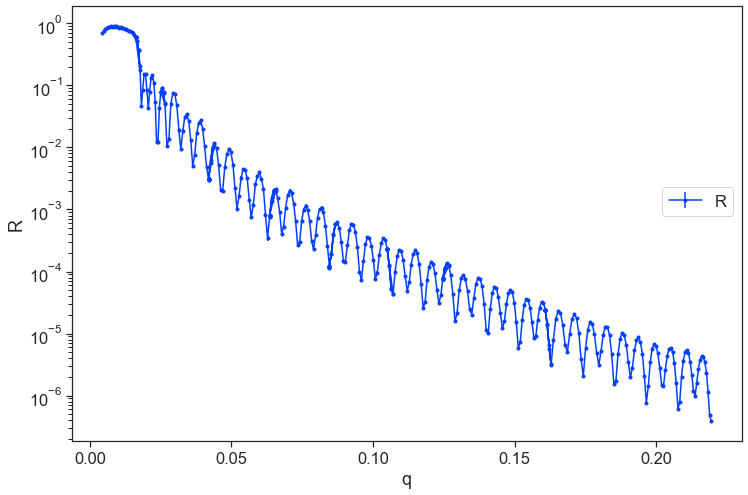

In [174]:
### this code collects the corrected data into a dataframe and plots the reflectivity profile

columns_final = ['Q','R','R_err'] #Removed HOS from the processed data
#columns_final_ReMag = ['Q','R']

if len(Refl_corr)==0:
    refl_final = refl[['Q', 'R', 'R_err']]
else:
    refl_final = pd.DataFrame(Refl_corr,columns=columns_final)

refl_q_final = refl_final.set_index('Q')
ax = refl_q_final["R"].plot(marker='o',ms=3,logy=True,figsize=(12,8),yerr=refl_q_final["R_err"])
axes = plt.gca()
ax.set(xlabel='q',ylabel='R')
ax.legend(loc='lower right',bbox_to_anchor=(1.0,0.5))
#ax = refl_q_final["HOS"].plot(secondary_y = True, marker='o',ms=3,logy=False)
#ax.set(xlabel='q',ylabel='HOS')
ax.legend(loc='lower right',bbox_to_anchor=(1.0,0.5))
#print(refl_q_final)
#plt.xlim(0,0.05)


In [175]:
refl

,Q,R,R_err,HOS,HES
10,0.004422,0.708681,0.006700,12.0,100.0
11,0.004917,0.757659,0.007154,12.0,100.0
12,0.005403,0.816484,0.007699,12.0,100.0
13,0.005898,0.848660,0.007998,12.0,100.0
14,0.006385,0.860403,0.008107,12.0,100.0
15,0.006880,0.883414,0.008320,12.0,100.0
16,0.007366,0.891083,0.008392,12.0,100.0
17,0.007861,0.888889,0.008371,12.0,100.0
18,0.008347,0.891147,0.008392,12.0,100.0
19,0.008842,0.864924,0.008148,12.0,100.0


In [26]:
"""

CSV Save

"""
#This code saves the processed data and meta-data into a csv file for loading into python
import os
datapath = 'C:/users/tjf2/Documents/'
savename = 'HomoP2_CEdge_284pt4'

#path_s = pathlib.Path('C:/users/tjf2/Documents/ALS Beamtime/2020 Nov/LateNov_Data/Late_Nov_Summary/MF116Old/ppol/284eV')

#refl_q_final.to_csv((datapath +savename+'_DATA1.csv'))

if not os.path.exists((datapath +'/meta_data/')):
    os.makedirs((datapath +'/meta_data/'))

refl_final.to_csv((datapath +savename+'_DATA.csv'), index=False)
meta.to_csv((datapath +'/meta_data/'+ savename + '_META.csv'), index=False)
